# Setup Jupyter notebook

In [1]:
from pathlib import Path
import sys

notebook_directory_parent = Path.cwd().resolve().parent.parent.parent
if str(notebook_directory_parent) not in sys.path:
    sys.path.append(str(notebook_directory_parent))

# Setup to use Python libraries/modules

In [2]:
from CuISOX.DataWrangling.Kaggle.DigitRecognizer import ProcessDigitsData
from CuISOX.utilities.configure_paths import DataPaths
from CuISOX.utilities.DataIO.KagglePaths import KagglePaths

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
data_paths = DataPaths()
kaggle_paths = KagglePaths()
kaggle_data_file_paths = kaggle_paths.get_all_data_file_paths()
digit_paths = kaggle_data_file_paths["DigitRecognizer"]

# Load Data
See [Long-Short Term Memory with Pytorch](https://www.kaggle.com/code/kanncaa1/long-short-term-memory-with-pytorch)

In [4]:
training_data_paths = DataPaths.get_path_with_substring(digit_paths, "train")
training_data_path = data_paths.Kaggle() / training_data_paths[0]
print(training_data_path)

/cuBlackDream/Data/Kaggle/DigitRecognizer/digit-recognizer/train.csv


In [6]:
# This uses a module that does all the subsequent, following, steps.Those steps were done to
# explicitly show each step. Either use the module that wraps up all those steps or step
# through the steps.

process_digits_data = ProcessDigitsData()

process_digits_data.parse_csv(training_data_path)
process_digits_data.load_data()

print(len(process_digits_data.training_loader.dataset))
print(len(process_digits_data.test_loader.dataset))

assert (len(process_digits_data.training_loader.dataset) == 33600)
assert (len(process_digits_data.test_loader.dataset) == 8400)

33600
8400


Starting from here are all the steps, explicitly shown, as the same as using ProcessDigitsData.

In [14]:
train = pd.read_csv(training_data_path, dtype= np.float32)
print(train.columns.tolist())
print(train.size)
print(train.shape)

['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90',

Split data into features(pixesl) and labels (numbers from 0 to 9)
See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In this case, y is "categorical" data, such that y can be from 0, 1, to 9; i.e. y is a non-negative integer.
X in this case has D = 784 features and we normalize by 255. Each row is a data sample, N = 42000.

In [17]:
y_targets_numpy = train.label.values
X_features_numpy = train.loc[:,train.columns != "label"].values / 255 # normalization
X_features_train, X_features_test, y_targets_train, y_targets_test = train_test_split(
    X_features_numpy,
    y_targets_numpy,
    test_size = 0.2,
    random_state = 42)

Create feature and targets tensor for training set. We need a variable to accumulate gradients. Therefore, first create tensor, and then we'll create variable.

In [26]:
X_features_training = torch.from_numpy(X_features_train)
y_targets_training = torch.from_numpy(y_targets_train).type(torch.LongTensor) # data type is long

# Create feature and targets tensor for test set.
X_features_testing = torch.from_numpy(X_features_test)
y_targets_testing = torch.from_numpy(y_targets_test).type(torch.LongTensor) # data type is long

print(type(X_features_training), type(y_targets_training))

<class 'torch.Tensor'> <class 'torch.Tensor'>


## Model Parameters and Sizes, Configuration

Batch size, epoch, and iteration

Suppose $B \equiv$ batch size.

Take the total number of samples $N$ and divide by $B$ so to get "number of batches". Given $N_{\text{iters}} \equiv$ total number of iterations, with each iteration doing 1 batch, we can get the total number of epochs.

In [22]:
batch_size = 100
n_iters = 6000
num_epochs = int( n_iters / (len(X_features_training) / batch_size))
print("Epoch Number: ", num_epochs)

33600 torch.Size([33600, 784])


In [ ]:
# Pytorch training and test sets
training = TensorDataset(X_features_training, y_targets_training)
testing = TensorDataset(X_features_testing, y_targets_testing)

# Data Loader
training_loader = DataLoader(training, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

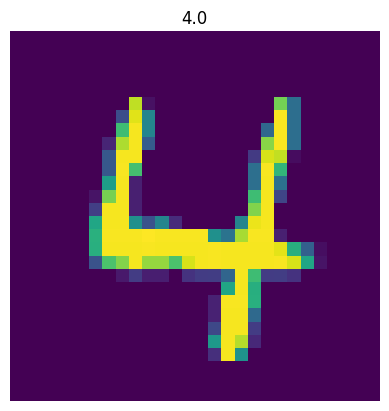

In [28]:
# Visualize one of the images in data set.
plt.imshow(X_features_numpy[42].reshape(28, 28))
plt.axis("off")
plt.title(str(y_targets_numpy[42]))
plt.show()

## Exploring Training Data

In [7]:
training_data_iterator = enumerate(process_digits_data.training_loader)

In [9]:
i, (image_batch, batch_labels) = training_data_iterator.__next__()

In [11]:
print(i)
print(type(image_batch))
print(type(batch_labels))
print(image_batch.shape)
print(batch_labels.shape)
print(image_batch.size())
print(batch_labels.size())

0
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([100, 784])
torch.Size([100])
torch.Size([100, 784])
torch.Size([100])


`.view()` Returns a new tensor with the same data as self tensor but of a different *shape*. See [torch.tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)

In [13]:
image_batch_transformed = image_batch.view(-1,  28, 28).requires_grad_()
print(type(image_batch_transformed))
print(image_batch_transformed.shape)
print(image_batch_transformed.size())

<class 'torch.Tensor'>
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
